In [1]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import os
import warnings
warnings.filterwarnings('ignore')

from cloudbandpy.load_driver import run_load_data

from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import create_list_of_dates, load_ymlfile, add_startend_datetime2config, write_cloud_bands_to_netcdf


Load configuration file and make adjustements for this test case

In [2]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Make sure that the period for the cloud bands cover the same period as the example data
config_event["startdate"] = "20210223.00"
config_event["enddate"] = "20210227.00"

dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["load_saved_files"] = False
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False
config_event["save_cloudbands_netcdf"] = True

print(config)

2024-05-13 13:07:45,834 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'run_inheritance_tracking': True, 'startdate': '20160101.00', 'enddate': '20160130.00', 'domain': 'southPacific', 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'clouddata_path': './ERA5/netcdf/3hourly/surface_level/', 'varname_infilename': 'top_net_thermal_radiation', 'qd_var': True, 'datatimeresolution': 3.0, 'period_detection': 24.0, 'olr_convert2wm2': True, 'varname': 'ttr', 'timecoord_name': 'time', 'xcoord_name': 'longitude', 'ycoord_name': 'latitude', 'select_djfm': False, 'parameters_file': './cloudbandPy/parameters/parameters_southhemisphere.yml', 'saved_dirpath': './cloud_band_files', 'save_dailyvar': False, 'save_listcloudbands': True, 'save_cloudbands_netcdf': False, 'load_saved_files': False, 'dir_figures': './cloud_band_figures', 'fig_detection_process': False, 'fig_time_evolution_object': False, 'fig_time_evolution_var_cloudband': False, 'fig_overlay_cloudband': False, 'fig_show_bbox_around_blobs': False, 'fig_inheritance_trac

Get OLR on 3-hourly data (one hour mean from ERA5)

In [3]:
config_event["qd_var"] = True
olr2process, parameters, lats, lons, _ = run_load_data(config_event)

2024-05-13 13:07:46,093 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-05-13 13:07:46,097 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-05-13 13:07:46,097 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-05-13 13:07:46,098 - io_utilities.load_dataset - INFO: Loading 2016 --> 2016
2024-05-13 13:08:28,848 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-05-13 13:08:28,870 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-05-13 13:08:29,719 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-05-13 13:08:29,737 - io_utilities.load_dataset - INFO: Dataset loaded


Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [4]:
add_startend_datetime2config(config_event)
listofdates = create_list_of_dates(config_event)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

5 dates created from 2021-02-23 00:00:00 to 2021-02-27 00:00:00


Load data

In [5]:
olr2process, parameters, lats, lons, resolution = run_load_data(config_event)

2024-05-13 13:08:29,783 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-05-13 13:08:29,829 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-05-13 13:08:29,830 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-05-13 13:08:29,830 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2024-05-13 13:08:53,600 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-05-13 13:08:53,623 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-05-13 13:08:53,760 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-05-13 13:08:53,777 - io_utilities.load_dataset - INFO: Dataset loaded


Run detection

In [6]:
(
    fill_binarize_data,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_map,
    list_of_candidates,
    list_of_cloud_bands,
) = detection_workflow(
    var2process=olr2process,
    parameters=parameters,
    latitudes=lats,
    longitudes=lons,
    resolution=resolution,
    listofdates=listofdates,
    config=config,
)

2024-05-13 13:08:53,814 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-05-13 13:08:54,456 - cb_detection.detection_workflow - INFO: Cloud band detection done


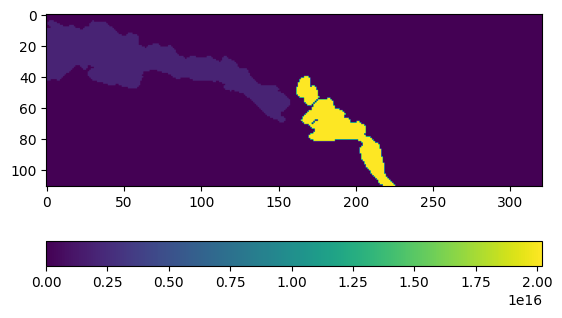

In [7]:
plt.imshow(cloud_bands_map[1])
plt.colorbar(orientation='horizontal')

Save to netCDF file

In [8]:
try: os.remove(f"cloud_bands_{config_event['startdate'][:4]}.nc")
except FileNotFoundError: print(f"File not found.")
write_cloud_bands_to_netcdf(list_of_cloud_bands=list_of_cloud_bands, cloud_band_array=cloud_bands_map, lons=lons, lats=lats, config=config_event)

File not found.


In [12]:
ds = nc.Dataset(f"cloud_band_files/cloud_bands_{config_event['startdate']}-{config_event['enddate']}-{config_event['domain']}.nc", "r")
cb = ds.variables["cloud_band_mask"][...]
# print(np.unique(cb))
angle = ds.variables["angle"][...]
print(angle[0])

[78.27320861816406 42.0500602722168]


[0.0000000e+00 2.0210224e+15 2.0210224e+16]


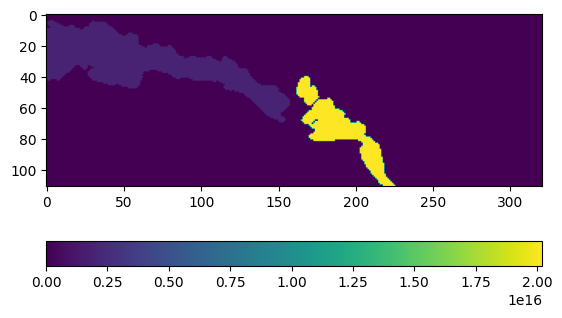

In [13]:
plt.imshow(cb[1])
plt.colorbar(orientation='horizontal')
print(np.unique(cb[1]))